Blockbusting in the 21st Century?: Minority Move-ins and Neighborhood Home Value Appreciation
===

## Introduction


How does a slight shift in neighborhood demographics affect house price appreciation? 
I am using the [**Fannie Mae (FNMA) \& Freddie Mac (FHLMC)**](https://web.archive.org/web/20240914151448/https://www.fhfa.gov/data/single-family-census-tract-file) data to analyze the demographics of move-ins on a census-tract level. This, with the census-level demographic data [**(ACS)**](https://www.nhgis.org/), can provide an estimate of a quantity of minority "move-ins". I am seeing the extent to which this has an effect on the appreciation in home values [(**Zillow ZHVI**)](https://www.zillow.com/research/data/)

My **y-variable** is census-tract property value appreciation. My main **explanatory variables** are minority move-ins and previous neighborhood demographics. I will be controlling for income.

Racial residential segregation has existed, in some form or another, throughout the history of the United States. Redlining, covenants, blockbusting. 

## Data Loading

We start by loading libraries. For dataframes we are using `pandas`, for plots we are using `pyplot` from `matplotlib`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Because the data is in ``.txt`` format, with no column headers, and is in many different files for different years and loan types, some light data cleaning is required. To begin, we set up short titles for each column based on the data dictionary provided, and create a list of columns we do not need.

In [2]:
def read_columns_from_txt(filename):
    data = {}
    with open(filename, "r") as f:
        for line in f:
            key, value = line.split("=", 1)
            data[key.strip()] = eval(value.strip())
    return data

columns_data = read_columns_from_txt("data/columns.txt")
cols = columns_data["cols"]
cols_pre2018 = columns_data["cols_pre2018"]
dropcols = columns_data["dropcols"]
dropcols_pre2018 = columns_data["dropcols_pre2018"]
cols_2013 = columns_data["cols_2013"]

We next must load our data using these columns. I create a `load_loans` method to make it easier to modify the years we load. For this project, we are focusing on some of the earliest base years possible (primarily due to computing constraints). In the future, I am interested in looking at moving base years.

In [3]:
def load_loans(years):
    loans_list = []
    for year in years:
        if year >= 2018: # The data format changes in 2018
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols).drop(columns=dropcols) for file in files],
                ignore_index=True
            )
        else:
            files = [f"data/sf/fhlmc_sf{year}c_loans.txt", f"data/sf/fnma_sf{year}c_loans.txt"]
            loans_year = pd.concat(
                [pd.read_csv(file, sep=r"\s+", header=None, names=cols_2013).drop(columns=dropcols_pre2018) for file in files],
                ignore_index=True
            )
        loans_year["year"] = year
        loans_list.append(loans_year)
        print(f"Processed {year}", end=" ")
    return pd.concat(loans_list, ignore_index=True)

In [74]:
loans = load_loans([2009, 2010, 2012, 2013]) # Please forgive the print statement! The full data can take upwards of 20 mins to load.

Processed 2009 Processed 2010 Processed 2012 Processed 2013 

I picked 2011 and 2012 as my "lending years" as they are some of the earliest possible years after the financial crisis. I picked 2019 as my final "test" year as it is the last year before COVID.

Next, we analyze each loan to determine how many "minority move-ins" it corresponds to. For the purposes of this project, a "minority move-in" refers to a new home purchase by a black or hispanic borrower or coborrower

In [75]:
loans = loans[loans['purpose'] == 1]

In [76]:
# Define race and ethnicity sets
races_set = {3}
ethnicities_set = {1}

# Extract relevant borrower and co-borrower race/ethnicity columns
borrower_races = loans[[col for col in loans.columns if col.startswith("borrower_race")]]
coborrower_races = loans[[col for col in loans.columns if col.startswith("coborrower_race")]]
borrower_ethnicities = loans[[col for col in loans.columns if col.startswith("borrower_ethnicity")]]
coborrower_ethnicities = loans[[col for col in loans.columns if col.startswith("coborrower_ethnicity")]]

# Check if any race or ethnicity belongs to minority groups
borrower_minority = borrower_races.isin(races_set).any(axis=1) | borrower_ethnicities.isin(ethnicities_set).any(axis=1)
coborrower_minority = coborrower_races.isin(races_set).any(axis=1) | coborrower_ethnicities.isin(ethnicities_set).any(axis=1)

# Assign values efficiently
loans["early_mmi"] = np.where((loans["year"] < 2011) & (borrower_minority & coborrower_minority), 2,
                              np.where((loans["year"] < 2011) & (borrower_minority | coborrower_minority), 1, 0))
loans["late_mmi"] = np.where((loans["year"] > 2011) & (borrower_minority & coborrower_minority), 2,
                             np.where((loans["year"] > 2011) & (borrower_minority | coborrower_minority), 1, 0))

loans["early_move_ins"] = np.where(loans["year"] < 2011, 1, 0)
loans["late_move_ins"] = np.where(loans["year"] > 2011, 1, 0)

Finally, we add a column with the full census tract code for future merging

In [77]:
loans['longtract'] = loans['state_fips'].astype(str).str.zfill(2) + loans['county_fips'].astype(str).str.zfill(3) + loans['census_tract'].astype(str).str.zfill(6)

To truly understand the rate of minority move-ins, we must control for neighborhood demographics. The **2010 US Census Data** provides this information (total population, white population, black population)

In [78]:
cols_tract = ['YEAR', 'ZCTAA','U7J001', 'U7J002', 'U7J003', 'U7J004', 'U7J005', 'U7J006', 'U7J007', 'U7J008']
tract_data = pd.read_csv('data/census/nhgis0009_ds258_2020_zcta.csv')[cols_tract]
tract_data.rename(columns={
    'YEAR': 'year',
    'ZCTAA': 'zip', 
    'U7J001': 'total_pop', 
    'U7J002': 'white', 
    'U7J003': 'black', 
    'U7J004': 'native_american', 
    'U7J005': 'asian', 
    'U7J006': 'pacific_islander', 
    'U7J007': 'other_race', 
    'U7J008': 'two_or_more'}, inplace=True)

Next, we load in the Zillow data for information about home prices

In [79]:
zhvi = pd.read_csv('data/zhvi/Zip_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month (1).csv')

The Zillow data is based on zip-code, but all our other data is based on census tract. As a result, we use a Crosswalk File from HUD.

In [80]:
crosswalk = pd.read_excel('data/census/ZIP_TRACT_122024.xlsx')

Next, we merge the loan data into our crosswalk. We aggregate on each census tract.

In [81]:
loans_grouped = loans.groupby(['longtract', 'msa_code'])[['early_mmi', 'late_mmi', 'early_move_ins', 'late_move_ins']].sum().reset_index()
loans_grouped['longtract'] = loans_grouped['longtract'].astype(str).str.zfill(11)
crosswalk['TRACT'] = crosswalk['TRACT'].astype(str).str.zfill(11)
loans_grouped['longtract'] = loans_grouped['longtract'].str.rstrip('.0')
loans_crosswalk = loans_grouped.merge(crosswalk, left_on='longtract', right_on='TRACT', how='inner')

Now that we have loan data, we merge with our **Census data**, and then filter for areas that are majority white.

In [82]:
loans_census = loans_crosswalk.merge(tract_data, left_on='ZIP', right_on='zip', how='left')
threshold_white = 0.5  # We only look at areas that are majority white
loans_census_filter = loans_census[(loans_census['white'] / loans_census['total_pop'] > threshold_white)]

Now we merge **Zillow data**, and find the change in home values of an area from 2012 to 2023 (end of move-in data to present)

In [83]:
loans_zhvi = loans_census_filter.merge(zhvi, left_on='zip', right_on='RegionName', how='left')
loans_zhvi[f'avg_value_2010'] = loans_zhvi[[f'2010-10-31', f'2010-11-30', f'2010-12-31']].mean(axis=1)
for year in range(2011, 2020):
    loans_zhvi[f'avg_value_{year}'] = loans_zhvi[[f'{year}-10-31', f'{year}-11-30', f'{year}-12-31']].mean(axis=1)
    loans_zhvi[f'value_ratio_{year}'] = loans_zhvi[f'avg_value_{year}'] / loans_zhvi[f'avg_value_2010']
loans_zhvi = loans_zhvi.drop(columns=[col for col in loans_zhvi.columns if col[:4].isdigit()])

Next, we control for metropolitan area.

In [84]:
# Calculate the average value change per msa_code for each year in the range
for year in range(2011, 2020):
    loans_zhvi[f'msa_avg_value_ratio_{year}'] = loans_zhvi.groupby('msa_code')[f'value_ratio_{year}'].transform('mean')
    loans_zhvi[f'value_diff_{year}'] = loans_zhvi[f'value_ratio_{year}'] - loans_zhvi[f'msa_avg_value_ratio_{year}']

In [85]:
# loans_zhvi = loans_zhvi.drop(columns=['longtract', 'TRACT', 'RegionName', 'black', 'native_american', 'asian', 'pacific_islander', 'StateName', 'State', 'City', 'Metro', 'CountyName', 'SizeRank', 'RegionID'])
data_table = loans_zhvi.groupby('zip').agg({
    'total_pop': 'sum',
    'msa_code': 'min',
    'early_mmi': 'sum',
    'late_mmi': 'sum',
    'early_move_ins': 'sum',
    'late_move_ins': 'sum',
    'white': 'sum',
    'other_race': 'sum',
    'two_or_more': 'sum',
    # 'avg_value_2010': 'mean',
    'avg_value_2011': 'mean',
    'value_ratio_2011': 'mean',
    'avg_value_2012': 'mean',
    'value_ratio_2012': 'mean',
    'avg_value_2013': 'mean',
    'value_ratio_2013': 'mean',
    'avg_value_2014': 'mean',
    'value_ratio_2014': 'mean',
    'avg_value_2015': 'mean',
    'value_ratio_2015': 'mean',
    'avg_value_2016': 'mean',
    'value_ratio_2016': 'mean',
    'avg_value_2017': 'mean',
    'value_ratio_2017': 'mean',
    'avg_value_2018': 'mean',
    'value_ratio_2018': 'mean',
    'avg_value_2019': 'mean',
    'value_ratio_2019': 'mean',
    'msa_avg_value_ratio_2011': 'mean',
    'value_diff_2011': 'mean',
    'msa_avg_value_ratio_2012': 'mean',
    'value_diff_2012': 'mean',
    'msa_avg_value_ratio_2013': 'mean',
    'value_diff_2013': 'mean',
    'msa_avg_value_ratio_2014': 'mean',
    'value_diff_2014': 'mean',
    'msa_avg_value_ratio_2015': 'mean',
    'value_diff_2015': 'mean',
    'msa_avg_value_ratio_2016': 'mean',
    'value_diff_2016': 'mean',
    'msa_avg_value_ratio_2017': 'mean',
    'value_diff_2017': 'mean',
    'msa_avg_value_ratio_2018': 'mean',
    'value_diff_2018': 'mean',
    'msa_avg_value_ratio_2019': 'mean',
    'value_diff_2019': 'mean',
}).reset_index()
data_table['early_mmi_ratio'] = data_table['early_mmi'] / data_table['early_move_ins']
data_table['late_mmi_ratio'] = data_table['late_mmi'] / data_table['late_move_ins']
data_table['early_late_ratio'] = data_table['late_mmi_ratio'] - data_table['early_mmi_ratio'] # Positive: MMI higher in late period

We have now, finally loaded our data. We have our quantity of minority move-ins, previous demographic makeup of the neighborhood, previous home values, and home values after a few years. 

## Summary Statistics

In our `filtered_data` table, we have information about our explanatory variables (demographics), our independent variables (initial property value), and our outcome variable (final property value)

In [86]:
prop_values_summary = data_table[['avg_value_2012','avg_value_2023','value_change', 'change_from_metro']].describe().round(2)
prop_values_summary.columns = ['Average Property Value (2012, $)','Average Property Value (2023, $)', 'Change in Property Value (2012-2023, %)', 'Change in Property Value - Difference from MSA Average (%)']
prop_values_summary.index = ['Count', 'Mean', 'Standard Deviation', 'Minimum', '25th Percentile', 'Median', '75th Percentile', 'Maximum']
prop_values_summary.loc['Range'] = prop_values_summary.loc['Maximum'] - prop_values_summary.loc['Minimum']
prop_values_summary.loc['Count'] = prop_values_summary.loc['Count'].astype(int)

# Styling
styled_prop_vals = prop_values_summary.style.set_caption("Table 2: Final Home Value Summary Statistics")

# Apply table styles
styled_prop_vals = styled_prop_vals.set_table_attributes('style="width: 40%; margin: auto;"')

# Apply formatting
styled_prop_vals = styled_prop_vals.format({
    'Change in Property Value (2012-2023, %)': '{:,.2f}',
    'Average Property Value (2012, $)': '{:,.2f}',
    'Average Property Value (2023, $)': '{:,.2f}',
    'Change in Property Value - Difference from MSA Average (%)': '{:,.2f}'
})

# Caption formatting
styled_prop_vals = styled_prop_vals.set_table_styles([{
    'selector': 'caption',
    'props': [
        ('caption-side', 'top'),
        ('font-size', '20px'),
        ('font-style', 'italic'),
        ('text-align', 'center'),
        ('color', '#222')
    ]
}])

styled_prop_vals

KeyError: "['avg_value_2023', 'value_change', 'change_from_metro'] not in index"

These summaries exhibit, on the right, how incredibly high the variation in property values is across zip code tabulation areas (ZCTAs). 

In [ ]:
# TODO: Add geo-segmented table!
# TODO: Add more discussion

## Plots \& Figures

In [ ]:
# TODO: box whisker plot? violin plot?
# TODO: Vary by geography

### Time Series of $Y$ With Discrete $X$

<>:9: SyntaxWarning: invalid escape sequence '\d'
<>:9: SyntaxWarning: invalid escape sequence '\d'
C:\Users\emers\AppData\Local\Temp\ipykernel_3960\3673608865.py:9: SyntaxWarning: invalid escape sequence '\d'
  melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)


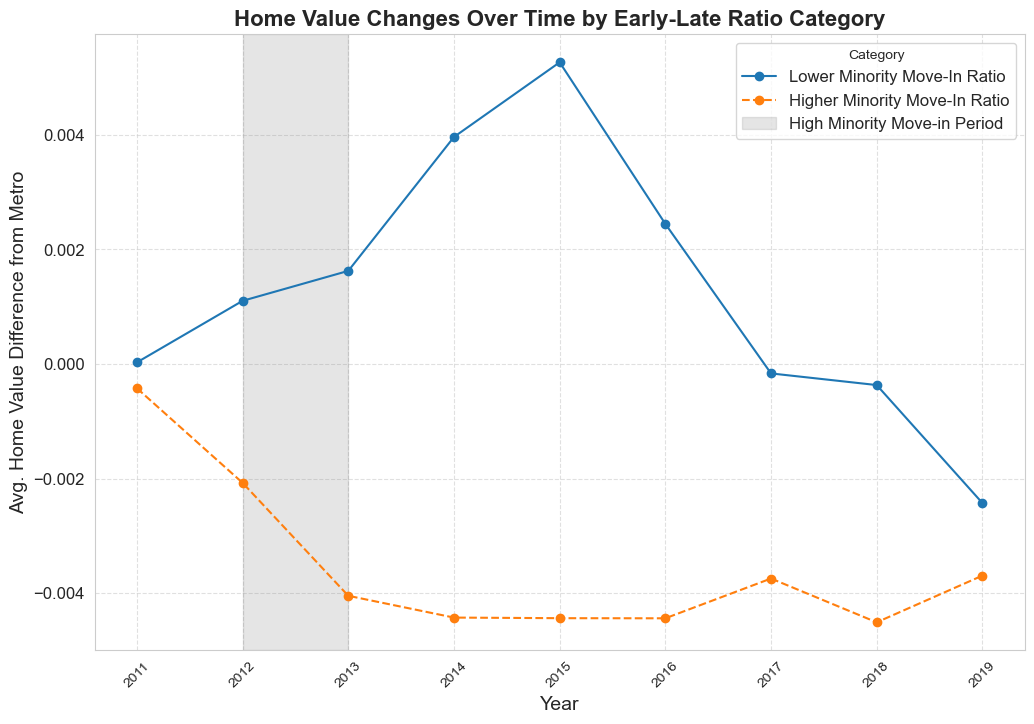

In [87]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))
# Categorize early_late_ratio into high and low
data_table['early_late_category'] = pd.cut(data_table['early_late_ratio'], bins=[-float('inf'), 0.00, float('inf')], labels=['lower', 'higher'])

# Melt the dataframe for easier plotting
melted_data = data_table.melt(id_vars=['early_late_category'], value_vars=[col for col in data_table.columns if col.startswith('value_diff_')], var_name='year', value_name='value_diff')
# Extract numeric year
melted_data['year'] = melted_data['year'].str.extract('(\d+)').astype(int)
# Compute average value difference per category and year
avg_value_change = melted_data.groupby(['early_late_category', 'year'], observed=False)['value_diff'].mean().reset_index()

# Define colors
colors = {"lower": "#1f77b4", "higher": "#ff7f0e"}  # Blue for low, Orange for high
linestyles = {"lower": "solid", "higher": "dashed"}  # Solid & dashed lines

# Plot each category with distinct styling
for category, data in avg_value_change.groupby('early_late_category', observed=False):
    plt.plot(data['year'], data['value_diff'], label=f'{category.capitalize()} Minority Move-In Ratio', color=colors[category], linestyle=linestyles[category], marker='o')

# Add shaded area for high minority move-in period
plt.axvspan(2012, 2013, color='gray', alpha=0.2, label='High Minority Move-in Period')

# Labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Avg. Home Value Difference from Metro', fontsize=14)
plt.title('Home Value Changes Over Time by Early-Late Ratio Category', fontsize=16, fontweight='bold')

# Improved legend
plt.legend(title='Category', fontsize=12)
plt.xticks(range(avg_value_change['year'].min(), avg_value_change['year'].max() + 1), rotation=45)
plt.yticks(fontsize=12)

# Grid styling
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

This graph shows that home values with more minority move-ins in 2014-2015 than in 2009-2010 had a relatively steep drop-off in value after 2015 relative to their metro area and homes that had fewer minority move-ins. It also shows that the home values in areas with more minority move-ins had been appreciating at a higher rate since 2011 than home values in areas with fewer, which is surprising.

### Scatterplot of Main $X$ and $Y$

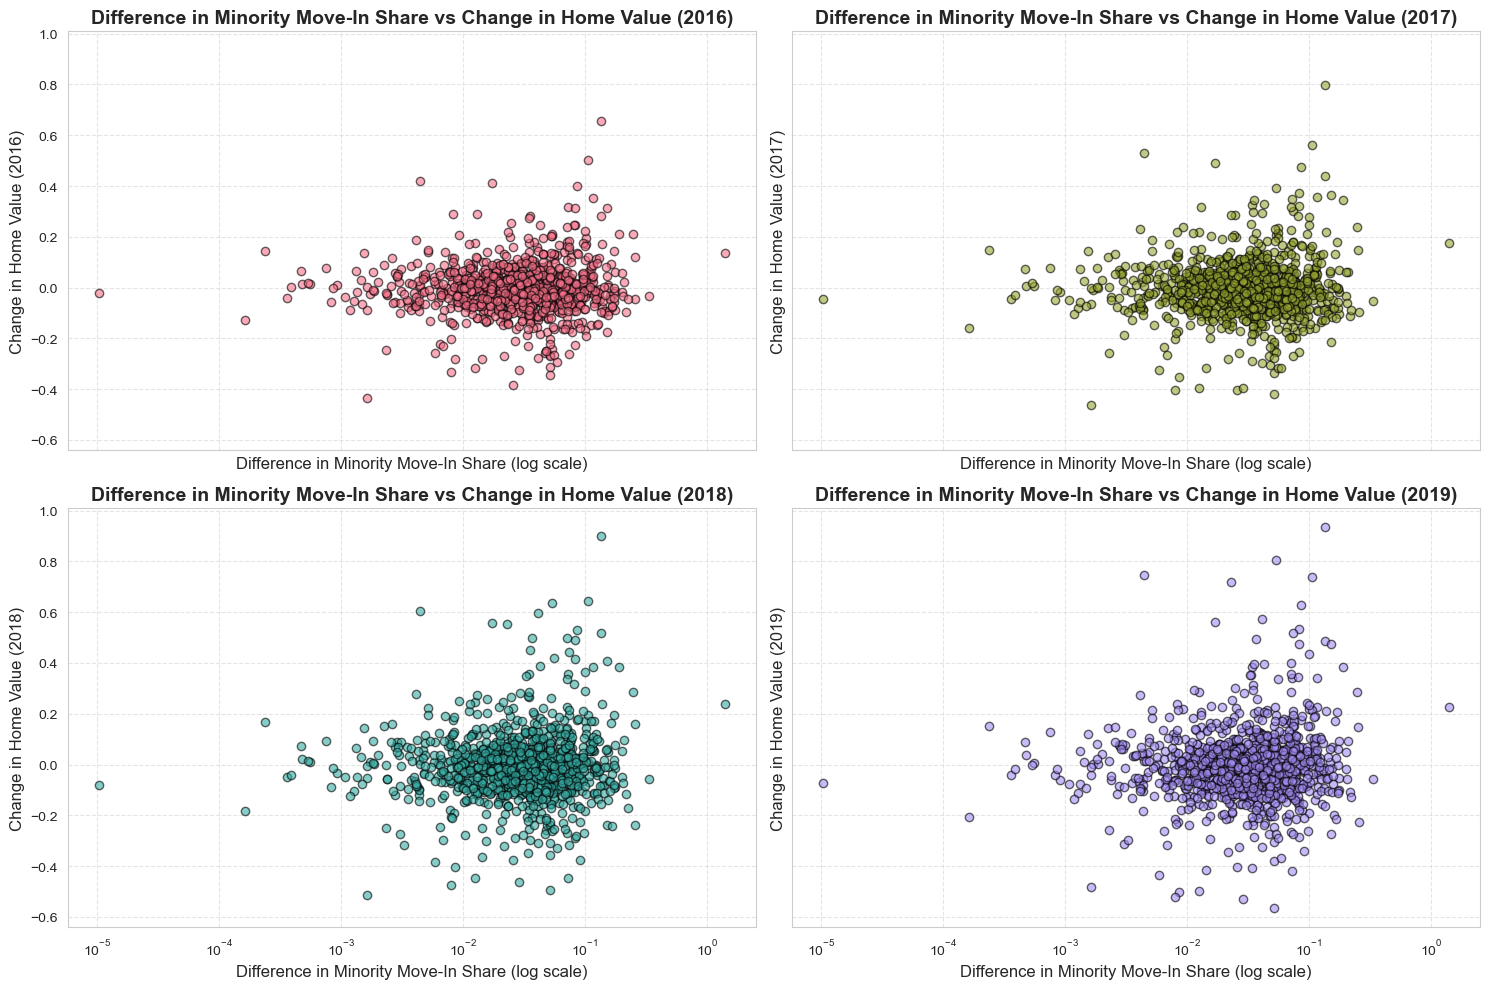

In [97]:
# Filter data
filtered_data = data_table[data_table['total_pop'].abs() > 100]

# Define color palette
colors = sns.color_palette("husl", 4)  # Distinct colors for better visibility

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=True)

years = [2016, 2017, 2018, 2019]
for i, year in enumerate(years):
    ax = axs[i // 2, i % 2]
    
    # Scatter plot with improved aesthetics
    ax.scatter(
        filtered_data['early_late_ratio'], 
        filtered_data[f'value_diff_{year}'], 
        alpha=0.6, color=colors[i], edgecolor='black'
    )
    ax.set_xscale('log')
    
    # Titles and labels
    ax.set_title(f'Difference in Minority Move-In Share vs Change in Home Value ({year})', fontsize=14, fontweight='bold')
    ax.set_xlabel('Difference in Minority Move-In Share (log scale)', fontsize=12)
    ax.set_ylabel(f'Change in Home Value ({year})', fontsize=12)
    
    # Grid styling
    ax.grid(True, linestyle="--", alpha=0.5)

# Improve layout
plt.tight_layout()
plt.show()


While Figure 1 indicates that at first there is some degree of negative association between an increase in minority move-in share and home appreciation relative to MSA, Figure 2 shows that data is so distributed that it is really hard to say that there truly is any association.

## Conclusion

My findings indicate that there is slight, if any association between my $x$ and $y$ variables. 

## References

Manson, S., Schroeder, J., Van Riper, D., Knowles, K., Kugler, T., Roberts, F., & Ruggles, S. (2024). *National Historical Geographic Information System: Version 19.0* [Dataset]. Minneapolis, MN: IPUMS. https://doi.org/10.18128/D050.V19.0